<a href="https://colab.research.google.com/github/Vish4github/Projects/blob/master/Amazon_Cell_Phone_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Libraries

In [0]:
from __future__ import print_function

import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

import matplotlib.pyplot as plt

from google.colab import files
from google.colab import drive as drive_colab
from google.colab import auth

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from oauth2client.client import GoogleCredentials

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# Authenticate user
## You must go to the link and copy access code
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load all the required files
file_id = '17-i-_a2zKwXJCNoOCt6R-Ezr2swO8x8r'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('items.csv')

file_id = '1flTqx4fnPVrk5zyydJDvh67z4IIN-2Ei'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('reviews.csv')

# Mount the drive to access files
drive_colab.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data

## File Upload
Upload all the required files

In [0]:
reviews = pd.read_csv('reviews.csv')
items = pd.read_csv('items.csv')

## Items Dataset
Ratings is numerical and mostly others are strings.   
No significant NA's in this dataset.  
We see Samsung has the highest phones with 346.  
Motorola is second with 105 and Apple has 63 phones.  

In [0]:
items.dtypes

asin              object
brand             object
title             object
url               object
image             object
rating           float64
reviewUrl         object
totalReviews       int64
price            float64
originalPrice    float64
dtype: object

In [0]:
items.head(1)

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0


In [0]:
items.isna().sum()

asin             0
brand            4
title            0
url              0
image            0
rating           0
reviewUrl        0
totalReviews     0
price            0
originalPrice    0
dtype: int64

In [0]:
  items.groupby('brand').agg({'asin':['count'], 'rating':['mean']})

,asin,rating
,count,mean
brand,,
ASUS,5,3.860000
Apple,63,3.782540
Google,38,3.771053
HUAWEI,32,4.021875
Motorola,105,3.643810
Nokia,44,3.386364
OnePlus,10,3.580000
Samsung,346,3.632659


## Reviews Dataset
Mostly string features.  
Very few NA's and can be ignored compared to rest of data.  


In [0]:
reviews.dtypes

asin             object
name             object
rating            int64
date             object
verified           bool
title            object
body             object
helpfulVotes    float64
dtype: object

In [0]:
reviews.isna().sum()

asin                0
name                2
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64

In [0]:
reviews.head()

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


## Merged Dataset

In [0]:
df = pd.merge(reviews, items, on='asin')
brand_count = df.groupby('brand').agg({'asin':['count'], 'rating_x':['mean']}).reset_index()
brand_count.columns = ["_".join(x) for x in brand_count.columns.ravel()]
brand_count.sort_values(by='asin_count',ascending=False)
df.shape

(67986, 17)

## Cleaning

In [0]:
df_reviews = df['body'].reset_index()
df_reviews.head()
df_reviews['body'] = df_reviews['body'].fillna("")
df_reviews['word_count'] = 0
df_reviews['most_common'] = ""
df_reviews['common_count'] = 0

In [0]:
df_reviews.head()

,index,body,word_count,most_common,common_count
0,0,I had the Samsung A600 for awhile which is abs...,0,,0
1,1,Due to a software issue between Nokia and Spri...,0,,0
2,2,"This is a great, reliable phone. I also purcha...",0,,0
3,3,"I love the phone and all, because I really did...",0,,0
4,4,The phone has been great for every purpose it ...,0,,0


In [0]:
stop_words = set(stopwords.words("english"))
for i in range(df_reviews.shape[0]):
    #Pick reviews one-by-one
    rev = df_reviews.iloc[i,1]
    
    # Make text lowercase, remove punctuation and remove words containing numbers
    rev = rev.lower()
    rev = rev.replace("."," .")
    rev = rev.replace("’"," ’")
    rev = re.sub('[%s]' % re.escape(string.punctuation), '', rev)
    rev = re.sub('\w*\d\w*', '', rev)

    # Tokenize the review
    tok_rev = word_tokenize(rev)
    
    #remove stop words
    filtered_rev = []
    for w in tok_rev:
        if w not in stop_words:
            filtered_rev.append(w)
    
    #Compute number of words
    df_reviews.iloc[i,2] = len(filtered_rev)
    
    #Find the most common word and its count
    fdist = FreqDist(filtered_rev)
    
    if len(filtered_rev) > 1:
        df_reviews.iloc[i,3] = fdist.most_common(1)[0][0]
        df_reviews.iloc[i,4] = fdist.most_common(1)[0][1]
    else:
        df_reviews.iloc[i,3] = ""
        df_reviews.iloc[i,4] = 0

KeyboardInterrupt: ignored

In [0]:
df_reviews.head()

,index,body,word_count,most_common,common_count
0,0,I had the Samsung A600 for awhile which is abs...,166,phone,7
1,1,Due to a software issue between Nokia and Spri...,68,sprint,3
2,2,"This is a great, reliable phone. I also purcha...",69,phone,3
3,3,"I love the phone and all, because I really did...",44,phone,5
4,4,The phone has been great for every purpose it ...,57,get,5


In [0]:
df_reviews['word_count'].mean()

28.143558968022827

In [0]:
top_words = df_reviews.groupby('most_common').agg({'index':['count']})
top_words.columns = ["_".join(x) for x in top_words.columns.ravel()]
top_words = top_words.sort_values(by='index_count',ascending=False)

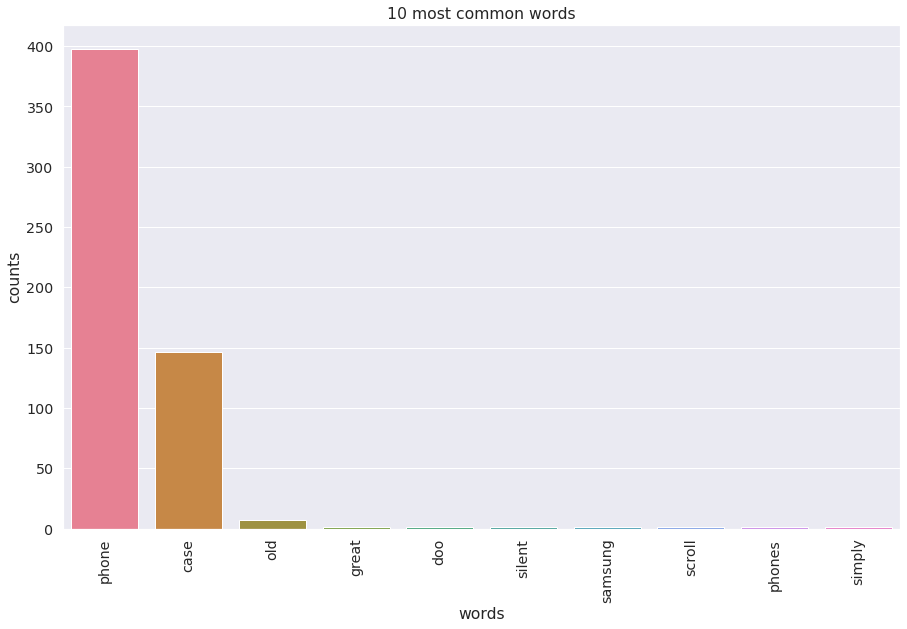

In [0]:
def plot_10_most_common_words(count_data, count_vectorizer):  
    words = count_vectorizer.get_feature_names()  
    total_counts = np.zeros(len(words))  
    for t in count_data:  
        total_counts+=t.toarray()[0] 
        count_dict = (zip(words, total_counts))  
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]  
        words = [w[0] for w in count_dict]  
        counts = [w[1] for w in count_dict]  
        x_pos = np.arange(len(words))   
     
    plt.figure(2, figsize=(15, 15/1.6180))  
    plt.subplot(title='10 most common words')  
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})  
    sns.barplot(x_pos, counts, palette='husl')  
    plt.xticks(x_pos, words, rotation=90)   
    plt.xlabel('words')  
    plt.ylabel('counts')  
    plt.show()
count_vectorizer = CountVectorizer(stop_words='english')  
count_data = count_vectorizer.fit_transform(df_reviews['body'])
plot_10_most_common_words(count_data, count_vectorizer)

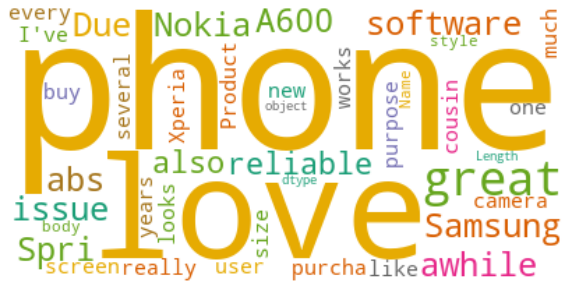

In [0]:
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
wc.generate(str(df_reviews.body))
plt.figure( figsize=(10,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Topic Modeling

In [0]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Just importing, imputing and cleaning the data again. Not required but for testing purposes

In [0]:
items_df=items.copy()
reviews_df=reviews.copy()
items_df['brand'] = np.where((items_df.asin == 'B0000SX2UC'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B01EWKHIAI'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07JHXX5YR'),'ASUS',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07T3KMJW8'),'Xiaomi',items_df.brand)
merged_data=pd.merge (items_df,reviews_df,how='left',on='asin')
merged_data.shape

(67986, 17)

## Cleaning using NLTK

Need further cleaning but this woud serve for now

In [0]:
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
keywords = merged_data["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
lemma = WordNetLemmatizer()
def clean_text(text):
    # Convert the text into lowercase
    text = text.lower()
    # Split into list
    wordList = text.split()
    # Remove punctuation
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    # Remove stopwords
    wordList = [word for word in wordList if word not in stop]
    # Remove other keywords
    wordList = [word for word in wordList if word not in keywords]
    # Lemmatisation
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)
clean_text('This is our collaboratory notebook for Data Mining Project. Okay you should be excited reading this!')

'collaboratory notebook data mining project okay excited reading'

In [0]:
merged_data["body"] = merged_data["body"].astype("str")
merged_data["clean_text"] = merged_data["body"].apply(clean_text)

Creating an Apple only dataset

In [0]:
merged_data["clean_text"].head().values
apple = merged_data[merged_data["brand"]=="Apple"].sort_values(by=["date"], ascending=False)

In [0]:
apple.head()

,asin,brand,title_x,url,image,rating_x,reviewUrl,totalReviews,price,originalPrice,name,rating_y,date,verified,title_y,body,helpfulVotes,clean_text
37805,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Zoriah Bradshaw,5,"September 9, 2019",True,Works fine,Works fine,NaN,work fine
42149,B07755LZ67,Apple,Apple iPhone 8 Plus 64GB Unlocked GSM Phone - ...,https://www.amazon.com/Apple-iPhone-Unlocked-G...,https://m.media-amazon.com/images/I/810MbmOEoq...,4.0,https://www.amazon.com/product-reviews/B07755LZ67,176,374.99,0.00,Timothy,5,"September 9, 2019",True,I like my new iPhone,It did not come with an AC charger,NaN,come ac charger
41893,B0775451TT,Apple,"Apple iPhone X, 256GB, Silver - For AT&T / T-M...",https://www.amazon.com/Apple-iPhone-Fully-Unlo...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B0775451TT,436,479.00,749.99,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh sto...
35704,B071JPQYGK,Apple,"Apple iPhone 7 Plus, AT&T Locked, 128GB - Jet ...",https://www.amazon.com/Apple-iPhone-Plus-128GB...,https://m.media-amazon.com/images/I/61dI0syR1r...,3.5,https://www.amazon.com/product-reviews/B071JPQYGK,12,284.99,549.99,Amazon Customer,1,"September 9, 2019",True,This product was a scam,The phone was either stolen or tossed by the o...,NaN,either stolen tossed owner att stated owner ow...
48696,B07D6TQP6F,Apple,"Apple iPhone X, 256GB, Silver - For AT&T (Rene...",https://www.amazon.com/Apple-iPhone-AT-256GB-R...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B07D6TQP6F,436,476.00,0.00,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh sto...


In [0]:
clean_text('Fuck that was good!')

'fuck good'

In [0]:
clean_text('No no thats not how you clean. Delete it')

'thats clean delete'

## LDA - Latent Dirichlet Allocation

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
n_topics=10
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=50, 
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

Creating a function for printing out the topics in good format

In [0]:
def print_topn_words(model, feature_names, topn):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-topn - 1:-1]])
        print(message)
    print()

In [0]:
t0 = time.time()
apple_tfidf = tfidf_vectorizer.fit_transform(apple["clean_text"])
apple_tfidf_feature_names = tfidf_vectorizer.get_feature_names()
lda.fit(apple_tfidf)
print("Below is the output from LDA model with {} topics (each includes Top10 words) for Apple.".format(n_topics))
print_topn_words(lda, apple_tfidf_feature_names, 10)
print("Done in %0.3fs." % (time.time() - t0))

Below is the output from LDA model with 10 topics (each includes Top10 words) for Apple.
Topic #0: new like look brand problem got work iphone came scratch
Topic #1: unlocked working buy day bought work problem use great seller
Topic #2: good great price battery new work iphone problem like look
Topic #3: screen scratch time came work like new seller battery buy
Topic #4: issue review purchase battery great iphone new came scratch day
Topic #5: condition charger came great good work time scratch new day
Topic #6: product refurbished bought happy purchase seller iphone buy time work
Topic #7: work love great seller problem iphone new got bought time
Topic #8: battery iphone life use day got problem seller great time
Topic #9: perfect far condition work happy great bought scratch new day

Done in 26.838s.


# Ngrams and plots

In [0]:
from textblob import TextBlob

In [0]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(merged_data["clean_text"], 10)
for word, freq in common_words:
    print(word, freq)



battery life 5894
sim card 3363
work great 2188
brand new 2120
sd card 1355
like new 1327
screen protector 1032
great price 983
easy use 903
work fine 768


In [0]:
df4 = pd.DataFrame(common_words, columns = ['Bigrams' , 'count'])
df4.head()

,Bigrams,count
0,battery life,5894
1,sim card,3363
2,work great,2188
3,brand new,2120
4,sd card,1355


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

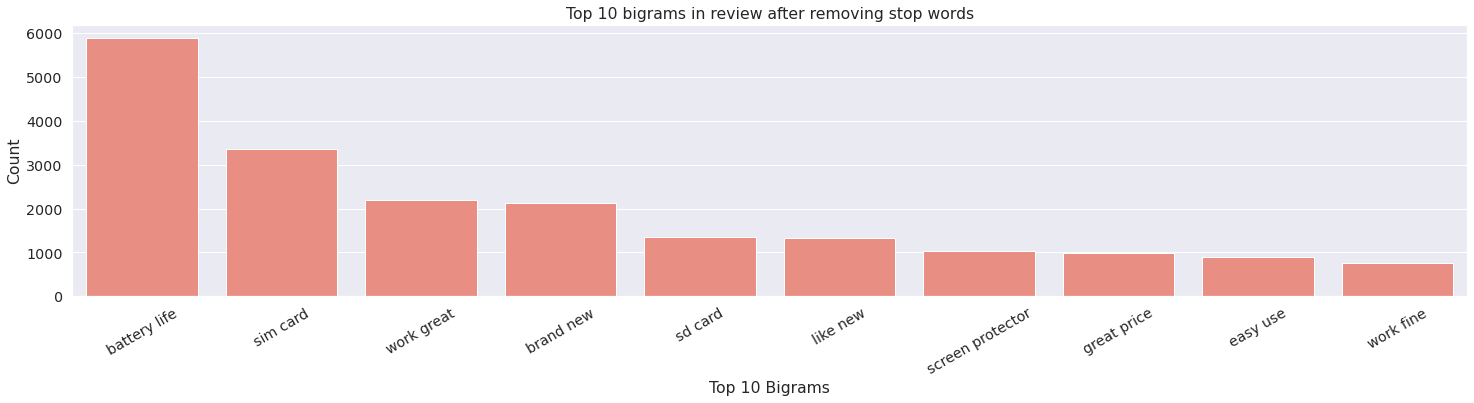

In [78]:
plt.figure(figsize=(25,5))
sns.barplot(x='Bigrams',y='count',data=df4,color="salmon")
plt.xlabel('Top 10 Bigrams')
plt.ylabel('Count')
plt.title('Top 10 bigrams in review after removing stop words')
plt.xticks(rotation=30);


In [0]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_trigrams = get_top_n_trigram(merged_data["clean_text"], 20)
for word, freq in common_words_trigrams:
    print(word, freq)

df5 = pd.DataFrame(common_words, columns = ['Trigrams' , 'count'])
df5.head()

great battery life 444
battery life good 368
battery life great 344
good battery life 342
look brand new 322
like brand new 308
micro sd card 264
look like new 194
long battery life 188
new sim card 178
sd card slot 177
looked brand new 173
work like new 170
galaxy s7 edge 167
battery life amazing 163
finger print reader 159
case screen protector 156
great great price 146
glass screen protector 141
mate 10 pro 131


,Trigrams,count
0,great battery life,444
1,battery life good,368
2,battery life great,344
3,good battery life,342
4,look brand new,322


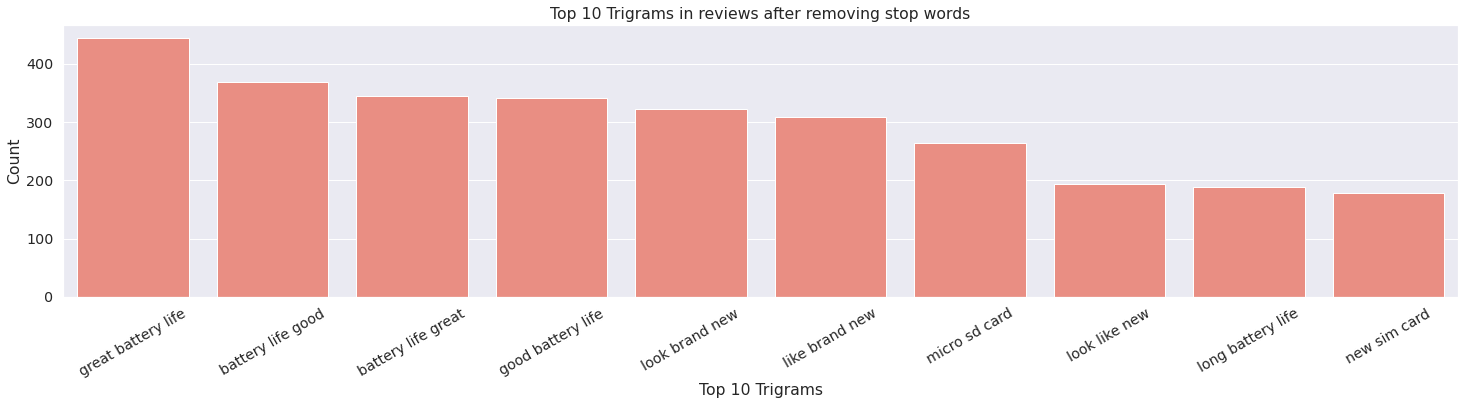

In [77]:
plt.figure(figsize=(25,5))
sns.barplot(x='Trigrams',y='count',data=df5,color="salmon")
plt.xlabel('Top 10 Trigrams')
plt.ylabel('Count')
plt.title('Top 10 Trigrams in reviews after removing stop words')
plt.xticks(rotation=30);